In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données

In [2]:
questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', usecols=[0, 3])
questions_df

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
13518,13518,5
13519,13519,5
13520,13520,5
13521,13521,5


In [3]:
data_types_dict={
    #'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    #'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32', 
    #'prior_question_had_explanation': 'boolean',
    }

In [4]:
train = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', usecols=data_types_dict.keys(), dtype=data_types_dict)[:1_000_000]#, skipfooter=90_000_000)
# skipfooter forces the use of the python engine which is much slower and too slow for this file.

In [5]:
train

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time
0,0,115,5692,0,1,NaN
1,56943,115,5716,0,1,37000.0
2,118363,115,128,0,1,55000.0
3,131167,115,7860,0,1,19000.0
4,137965,115,7922,0,1,11000.0
...,...,...,...,...,...,...
999995,26482248,20949024,8803,0,1,14000.0
999996,26516686,20949024,4664,0,1,17000.0
999997,26537967,20949024,4108,0,0,18000.0
999998,26590240,20949024,5014,0,0,6000.0


In [6]:
train = train[train.content_type_id == 0].drop('content_type_id', axis=1)

In [7]:
train = train.merge(questions_df, left_on="content_id", right_on="question_id").drop('content_id', axis=1)

In [8]:
train.sort_values(['user_id', 'timestamp'], inplace=True)

In [9]:
train

,timestamp,user_id,answered_correctly,prior_question_elapsed_time,question_id,part
0,0,115,1,NaN,5692,5
337,56943,115,1,37000.0,5716,5
579,118363,115,1,55000.0,128,1
760,131167,115,1,19000.0,7860,1
963,137965,115,1,11000.0,7922,1
...,...,...,...,...,...,...
207187,26482248,20949024,1,14000.0,8803,5
89100,26516686,20949024,1,17000.0,4664,5
86033,26537967,20949024,0,18000.0,4108,5
283089,26590240,20949024,0,6000.0,5014,5


# Construction des entrées

Pour le moment on conserve le prior question elapsed time au lieu de construire le current question elapsed time

In [10]:
train['timestamp_diff'] = train.groupby('user_id')['timestamp'].diff().fillna(0)

In [11]:
train.drop('timestamp', axis=1, inplace=True)

In [12]:
train = train[['user_id', 'question_id', 'part', 'answered_correctly', 'prior_question_elapsed_time', 'timestamp_diff']]

In [13]:
train.min() # on vérifie que le min est proche de 0 afin de ne pas perdre de place dans nn.embedding où les vecteurs sont alloués à partir de l'index 0

user_id                        115.0
question_id                      0.0
part                             1.0
answered_correctly               0.0
prior_question_elapsed_time      0.0
timestamp_diff                   0.0
dtype: float64

In [14]:
maximums = dict(train[['question_id', 'part', 'answered_correctly']].max())
maximums

{'question_id': 13522, 'part': 7, 'answered_correctly': 1}

In [15]:
train.dtypes # on vérifie que les variables catégorielles ont bien le type int

user_id                          int32
question_id                      int64
part                             int64
answered_correctly                int8
prior_question_elapsed_time    float32
timestamp_diff                 float64
dtype: object

In [16]:
train.fillna(0, inplace=True)

## Batches
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch  

In [17]:
#batch = [torch.tensor(x.drop('user_id', axis=1).values) for _, x in train.groupby('user_id')]
batch_cat = [torch.tensor(x[['question_id', 'part', 'answered_correctly']].values) for _, x in train.groupby('user_id')]
batch_cont = [torch.tensor(x[['prior_question_elapsed_time', 'timestamp_diff']].values, dtype=torch.float) for _, x in train.groupby('user_id')]

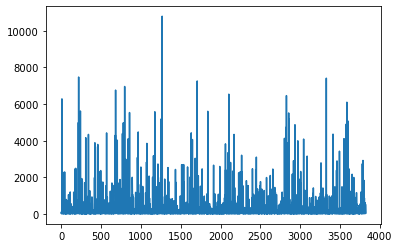

In [19]:
lengths = [len(el) for el in batch_cat]
plt.plot(lengths)

In [ ]:
unsorted_lengths = [len(x) for x in full_input_ids]

In [163]:
pad_sequence(batch).size()

torch.Size([10797, 3824, 5])

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [157]:
class RiiidEmbedding(nn.Module):
    def __init__(self, maximums, emb_size=16, dim=128):
        super().__init__()
        self.emb_size = emb_size
        self.question_emb = nn.Embedding(maximums['question_id']+1, emb_size)
        self.part_emb = nn.Embedding(maximums['part']+1, emb_size)
        self.answer_emb = nn.Embedding(maximums['answered_correctly']+1, emb_size)
        self.cont_emb = nn.Sequential(
            nn.Linear(2, emb_size),
            nn.LayerNorm(emb_size)
            )
        self.merge = nn.Linear(4*emb_size, dim)#, bias=False)

    def forward(self, x_cat, x_cont):
        if len(x_cat.size()) == 2:
            x_cat = x_cat.unsqueeze(0)
            x_cont = x_cont.unsqueeze(0)
        q_emb = self.question_emb(x_cat[:, :, 0])
        p_emb = self.part_emb(x_cat[:, :, 1])
        a_emb = self.answer_emb(x_cat[:, :, 2])
        cont_emb = self.cont_emb(x_cont)
        emb = torch.cat([q_emb, p_emb, a_emb, cont_emb], dim=2)
        emb = self.merge(emb)
        return emb

In [158]:
emb = RiiidEmbedding(maximums)

In [127]:
encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

In [160]:
transformer_encoder(b0)

tensor([[[-8.6441e-01, -5.9859e-01, -6.2929e-01,  ..., -1.3305e+00,
          -6.7819e-02, -2.2881e+00],
         [-8.5803e-01, -6.7275e-03,  2.1168e-01,  ..., -5.8472e-01,
           8.3090e-01, -9.0860e-01],
         [-1.5394e+00, -1.7216e+00, -9.0073e-01,  ..., -2.4470e-04,
          -5.8785e-01, -1.7513e+00],
         ...,
         [-8.2719e-01, -4.1712e-01,  1.1345e-01,  ..., -1.3247e+00,
          -2.3812e-01, -9.2698e-01],
         [-1.3272e+00, -9.0763e-01, -1.4901e-01,  ..., -1.0707e+00,
          -6.7082e-01, -6.3600e-01],
         [-1.5884e+00, -9.5384e-01, -8.9919e-02,  ..., -4.3705e-01,
           1.0705e-01, -1.1031e+00]]], grad_fn=<NativeLayerNormBackward>)